In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult

# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [2]:
time = '10'
date = '2023-04-14'
experiment = 'fba-redux-standard'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [3]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [4]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [5]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25."]
# generate carbon mistake in parca, efflux/influx proton gen, iron cheating, mass gen
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

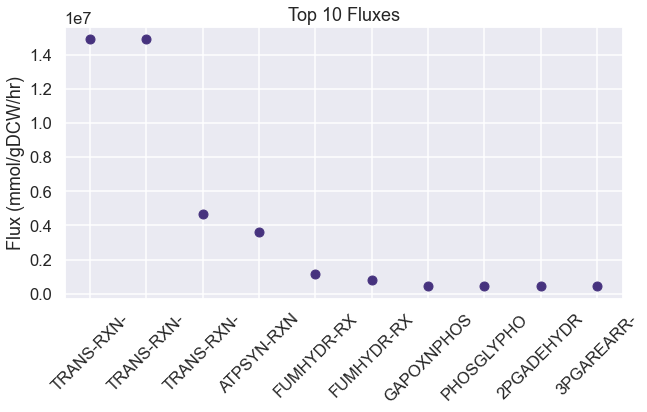

In [6]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(10, 5))
plt.plot(sim_fluxes.head(10), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(10)], [i[:10] for i in sim_fluxes.index[:10]], rotation=45)
plt.ylabel('Flux (mmol/gDCW/hr)')
plt.title('Top 10 Fluxes')
plt.show()

# Test changing nutrient composition

In [7]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'FRU[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [8]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["target_maintenance_flux"]).at[4, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]          73
2-KETOGLUTARATE[c]               187
2-PG[c]                           49
2K-4CH3-PENTANOATE[c]             72
4-AMINO-BUTYRATE[c]              161
                              ...   
WATER[c]                    22086088
XYLULOSE-5-PHOSPHATE[c]           89
ZN+2[c]                           89
ZN+2[p]                           53
glycogen-monomer[c]            35110
Name: 4, Length: 172, dtype: int64

In [9]:
model = NetworkFlowModel(reactions=stoichiometry, homeostatic_metabolites=list(dict(homeostatic).keys()))

In [10]:
model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

In [11]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   binary_kinetic_targets={},
                                   objective_weights={'secretion': 0.001, 'efficiency': 0.00001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

In [12]:
pd.Series(solution.exchanges).sort_values(ascending=False).head(10)

WATER[p]              1.736816e+07
FRU[p]                1.410108e+06
AMMONIUM[c]           1.375859e+06
OXYGEN-MOLECULE[p]    1.289748e+06
Pi[p]                 1.776750e+05
K+[p]                 5.145700e+04
SULFATE[p]            3.335100e+04
MG+2[p]               2.287000e+03
FE+2[p]               1.930000e+03
CA+2[p]               1.425000e+03
dtype: float64

In [13]:
pd.Series(solution.velocities).sort_values(ascending=False).head(10)

TRANS-RXN-145                                                                  1.736816e+07
ATPSYN-RXN (reverse)                                                           4.181745e+06
maintenance_reaction                                                           3.058992e+06
GAPOXNPHOSPHN-RXN                                                              2.307510e+06
PHOSGLYPHOS-RXN (reverse)                                                      2.307502e+06
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.          2.223745e+06
3PGAREARR-RXN (reverse)                                                        2.083406e+06
2PGADEHYDRAT-RXN                                                               2.083357e+06
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse)    1.893273e+06
RXN0-6717                                                                      1.410108e+06
dtype: float64

# Filter S matrix to only include nonzero fluxes.

In [14]:
# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in solution.velocities.items() if v != 0}

In [15]:
# Use nonzero_velocities to filter S matrix
S_matrix = model.Sd.loc[:, nonzero_velocities.keys()]

# remove rows of S_used that sum to zero.
S_matrix = S_matrix.loc[(S_matrix != 0).any(axis=1)]

In [16]:
nonzero_velocities

{'1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse)': 3851.0,
 '1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse)': 16094.999999999989,
 '1PFRUCTPHOSN-RXN': 1238117.9886565725,
 '1TRANSKETO-RXN (reverse)': 7926.0,
 '1TRANSKETO-RXN-D-SEDOHEPTULOSE-7-P/GAP//CPD-16551/XYLULOSE-5-PHOSPHATE.56. (reverse)': 48.0,
 '2-DEHYDROPANTOATE-REDUCT-RXN (reverse)': 1131.0000000000043,
 '2-ISOPROPYLMALATESYN-RXN': 56297.00000000001,
 '2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN': 300.0,
 '2-OCTAPRENYL-6-OHPHENOL-METHY-RXN': 300.0,
 '2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN': 300.0,
 '2-OCTAPRENYLPHENOL-HYDROX-RXN': 300.0,
 '2.3.1.157-RXN': 16505.000000000004,
 '2.5.1.19-RXN': 50577.00000000004,
 '2.5.1.64-RXN': 105.99999999999997,
 '2.7.1.148-RXN': 47391.00000000001,
 '2.7.7.60-RXN': 47391.00000000001,
 '2.8.1.6-RXN': 10.0,
 '2OXOGLUTARATEDEH-RXN': 248858.97731314722,
 '2PGADEHYDRAT-RXN': 2083356.977313149,
 '2TRANSKETO-RXN (reverse)': 50658.000000000044,
 '3-CH3-2-OXOBUTANOAT

In [17]:
S_matrix

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),1TRANSKETO-RXN-D-SEDOHEPTULOSE-7-P/GAP//CPD-16551/XYLULOSE-5-PHOSPHATE.56. (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
NAD[c],1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADH[c],-1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PROTON[c],-1,-1,1,0,0,-1,1,-1,1,1,...,0,0,-1,0,1,0,0,0,1,1
GLUCONATE[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADP[c],0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-3-hydroxymyristoyl-ACPs[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adenylated-ThiS-Proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ThiS-CoASH-proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thi-S[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First test. Single flux set. No eQuilibrator or regulation.

In [18]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = {k: nonzero_velocities[k] for k in S_matrix.columns}
vE = np.array([np.array(list(vE_dict.values()))])

In [19]:
Sd = S_matrix
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

Sd

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),1TRANSKETO-RXN-D-SEDOHEPTULOSE-7-P/GAP//CPD-16551/XYLULOSE-5-PHOSPHATE.56. (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
NAD[c],1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADH[c],-1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PROTON[c],-1,-1,1,0,0,-1,1,-1,1,1,...,0,0,-1,0,1,0,0,0,1,1
GLUCONATE[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADP[c],0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-3-hydroxymyristoyl-ACPs[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adenylated-ThiS-Proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ThiS-CoASH-proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thi-S[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
S_array = np.array(Sd)

# count number of times a value occurs in S_array
np.unique(S_array, return_counts=True)

(array([-8, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  8],
       dtype=int8),
 array([     2,      1,      3,      3,      5,     31,    956, 229633,
          1062,     39,      9,      3,      1,      2,      2]))

In [21]:
# K_eq = np.log(keq)
# K_eq_mod = K_eq[:, np.newaxis].T
# vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])

# n_flux_set = vE.shape[0]
n_flux_set = 1
Sr = None

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([vE, np.sign(vE)]), columns=Sd.columns,
             index=["$v_1$", "sign 1"])

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),1TRANSKETO-RXN-D-SEDOHEPTULOSE-7-P/GAP//CPD-16551/XYLULOSE-5-PHOSPHATE.56. (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
$v_1$,3851.0,16095.0,1.238118e+06,7926.0,48.0,1131.0,56297.0,300.0,300.0,300.0,...,25.0,3.0,119.0,31.0,4.0,2979.0,17162.0,16186.0,143.0,3.058992e+06
sign 1,1.0,1.0,1.000000e+00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00


In [22]:
# set up variables

n_met = len(Sd.index)
n_rxn = len(Sd.columns)

S_mol = np.array(Sd)
S = np.sign(S_mol) #
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S)
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())
S_s_mol = np.abs(S_mol)[S_s.nonzero()]
S_p_mol = np.abs(S_mol)[S_p.nonzero()]

# TODO Refactor all the below lines as one liners
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices.
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :] if Sr else None
met_a_nz = S_a_nz[0, :] if Sr else None

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well.
rxn_s_nz = S_s_nz[1, :]
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :] if Sr else None
rxn_a_nz = S_a_nz[1, :] if Sr else None

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape)
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) if Sr else None
n_Km_a = np.max(met_a_nz.shape) if Sr else None

c = cp.Variable([n_met, n_flux_set])
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define y vecs
y_s_t = []
y_p_t = []
y_i_t = []
y_a_t = []

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
# TODO Add molecularity here.
for i in range(n_flux_set):
    y_s_t.append(cp.multiply(S_s_mol, c[met_s_nz, i] - Km_s))
    y_p_t.append(cp.multiply(S_p_mol, c[met_p_nz, i] - Km_p))
    y_i_t.append(c[met_i_nz, i] - Km_i if n_Km_i else None)
    y_a_t.append(-(c[met_a_nz, i] - Km_a) if n_Km_a else None)

y_s = cp.vstack(y_s_t)
y_p = cp.vstack(y_p_t)
y_i = cp.vstack(y_i_t)
y_a = cp.vstack(y_a_t)

# saturation stacks
y_f_vec = [y_s]
y_r_vec = [y_p]
if n_Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if n_Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)

y_f = cp.hstack(y_f_vec)
y_r = cp.hstack(y_r_vec)

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_7866/2254429256.py:18: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  S_i_nz = np.array(S_i.nonzero())
/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_7866/2254429256.py:19: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  S_a_nz = np.array(S_a.nonzero())


In [23]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0) if Sr else S_s
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0) if Sr else S_p
n_alpha = np.sum(np.power(2, np.sign(S_s_comb).sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, np.sign(S_p_comb).sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act.
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)]) if Sr else np.zeros([n_alpha, len(met_s_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)]) if Sr else np.zeros([n_beta, len(met_p_nz)])

# to separate different reactions saturation terms to their individual reaction equations.
d_alpha = np.zeros(n_alpha, dtype=np.int64)
d_beta = np.zeros(n_beta, dtype=np.int64)


idx = 0

for i in range(n_rxn):

    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    # TODO This does not properly multiply by molecularity. Alternatively, generate C_alpha and
    # TODO beta without molecularity (first ==1) and then multiply by molecularity in the end.
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i)) if Sr else rxn_s_nz == i

    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i

    idx += r # add row #

idx = 0

for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i)) if Sr else rxn_p_nz == i

    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i

    idx += r # add row #

In [24]:
Sd.iloc[:, 227:230]

,PYRIMSYN1-RXN,PYRIMSYN3-RXN,PYRROLINECARBREDUCT-RXN-PRO/NAD//L-DELTA1-PYRROLINE_5-CARBOXYLATE/NADH/PROTON.54. (reverse)
NAD[c],0,0,1
NADH[c],0,0,-1
PROTON[c],3,0,-2
GLUCONATE[c],0,0,0
NADP[c],0,0,0
...,...,...,...
R-3-hydroxymyristoyl-ACPs[c],0,0,0
Adenylated-ThiS-Proteins[c],0,0,0
ThiS-CoASH-proteins[c],0,0,0
Thi-S[c],0,0,0


In [25]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []
denom_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for j in range(n_flux_set):
    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p

        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            LSE_expr.append(cp.hstack( [
                                         lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                         cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  + crev[i]
                                            - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                       ]
                                     )
                           )  # remove +1 here, could also have cfwd outside objec.

            denom_expr.append(cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) + cfwd[i],)


        # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed.
        if sign[j, i] == -1:
            LSE_expr.append(cp.hstack( [ lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  + cfwd[i]
                                            - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                       ]
                                     )
                           )

            denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])


#LSE_expr = cp.vstack(LSE_expr)
LSE_expr[0:10]

[Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (16,)),
 Expression(AFFINE, UNKNOWN, (24,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (24,))]

In [26]:
l = 0.001
e = 0.001
f = 0.000001
reg =  cp.sum(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.sum(cp.hstack([-Km_s, -Km_p])) # regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.norm1(cp.hstack([-Km_s, -Km_p])) # regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1)) # issue with matrix

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(len(LSE_expr)):
    loss += cp.norm1(cp.pos(cp.log_sum_exp(LSE_expr[i])))
for i in range(len(denom_expr)):
    loss += 0.01 * denom_expr[i]
loss += l * reg
loss += e * reg2
loss += f * reg3
#

In [27]:
constr = [cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) <= 18,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 18])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 18])



In [29]:
# haldane = []
# fwd_flux = []
#
# for i, r in enumerate(S.T):
#     Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
#     S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
#
#     Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
#     S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
#
#     haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])
#
# for j in range(n_flux_set):
#     for i, r in enumerate(S.T):
#         Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
#         S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
#
#         Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
#         S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
#
#         if sign[j, i] == 1:
#             fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus
#             # equilibrium.append(r @ c <= K_eq[i])
#
#         if sign[j, i] == -1:
#             fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus
#             # equilibrium.append(r @ c >= K_eq[i])
#
#
#     constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])
#
# constr.extend(haldane)
# constr.extend(fwd_flux)

In [30]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=False, solver=cp.ECOS)

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


52.00810985791868

In [31]:
# print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
# print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
# print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
# print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
#
# concs = np.exp(c.value).T
# for row in concs:
#     print('Concentration:', [f'{val:.4f}' for val in row])
#
# if n_Km_i:
#     print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
# if n_Km_a:
#     print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

In [32]:
for v in LSE_expr:
    #print(v.value)
    print(logsumexp(v.value))

-9.016658010230216e-07
-9.010928844199739e-07
-8.333029090090704e-07
-6.078295081701768e-07
-9.022073962361432e-07
-1.1291484500741689e-06
-1.7184411720272408e-06
-8.34596028953527e-07
-8.345950488486409e-07
-1.718441159259676e-06
-8.338661279250204e-07
-6.071909094962358e-07
-9.037232728825728e-07
-8.337300690386407e-07
-9.007189029075491e-07
-2.8743793769603343e-06
-1.128931861882343e-06
-4.591097013117995e-07
-6.071760386139324e-07
-9.021969515909944e-07
-4.6004464276938606e-07
-4.6003576598119267e-07
-6.094163242376105e-07
-6.134530129431326e-07
-6.084047574073104e-07
-6.073623661784211e-07
-3.3229062362805095e-07
-6.094899926978314e-07
-3.387254685072172e-07
-3.3732929330398953e-07
-6.071008554209278e-07
-6.070374715672067e-07
-6.08734810392253e-07
-9.004257121025816e-07
-6.063097415243135e-07
-9.007393340088043e-07
-9.007070277400331e-07
-4.6402445161297656e-07
-6.072183847960488e-07
-6.071957023290331e-07
-6.072024432701717e-07
-4.654160312700384e-07
-8.337674642922011e-07
-6.85

Perfect? Wow.

# Check flux reconstruction with inhibition/activation

In [33]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[3.85100347e+03 1.60950145e+04 1.23811902e+06 7.97400485e+03
 1.13100102e+03 5.62970636e+04 3.00000516e+02 3.00000250e+02
 3.00000250e+02 3.00000516e+02 1.65050138e+04 5.05770307e+04
 1.06000096e+02 4.73910395e+04 4.73910427e+04 1.00000287e+01
 2.48859258e+05 2.08335793e+06 5.06580308e+04 1.13100102e+03
 5.05840233e+04 5.05840233e+04 3.00000183e+02 4.00000245e+00
 1.96800120e+03 3.07090187e+04 2.08340667e+06 3.00000183e+02
 7.77200263e+03 1.65050056e+04 7.51950457e+04 8.31240505e+04
 5.68000346e+02 1.11928101e+05 9.02660547e+04 3.92070353e+04
 3.92070353e+04 1.00000046e+01 4.64800282e+04 4.64580282e+04
 4.64800282e+04 7.00000326e+00 3.33480278e+04 9.90000679e+01
 1.07100065e+03 2.82300172e+03 2.77348133e+05 3.62220556e+04
 3.33480278e+04 5.30000442e+01 4.39090202e+04 5.71510347e+04
 4.39580545e+04 8.14150494e+04 4.79000163e+03 3.62220167e+04
 6.46800802e+03 3.62390167e+04 3.63320559e+04 2.95130454e+04
 1.28031055e+05 4.27028182e+05 6.73230760e+04 4.39840267e+04
 4.24060354e+04 1.131000

In [34]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
# df_reconstr_comp

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


[Text(0, 0, 'TRANS-RXN-145'),
 Text(0, 1, 'ATPSYN-RXN (reverse)'),
 Text(0, 2, 'maintenance_reaction'),
 Text(0, 3, 'GAPOXNPHOSPHN-RXN'),
 Text(0, 4, 'PHOSGLYPHOS-RXN (rev'),
 Text(0, 5, 'NADH-DEHYDROG-A-RXN-'),
 Text(0, 6, '3PGAREARR-RXN (rever'),
 Text(0, 7, '2PGADEHYDRAT-RXN'),
 Text(0, 8, 'TRANS-RXN0-545[CCO-P'),
 Text(0, 9, 'RXN0-6717'),
 Text(0, 10, 'TRANS-RXN0-582-FRU/P'),
 Text(0, 11, 'TRANS-RXN0-474'),
 Text(0, 12, 'RXN-21817-CPD-9956/P'),
 Text(0, 13, '1PFRUCTPHOSN-RXN'),
 Text(0, 14, 'TRIOSEPISOMERIZATION'),
 Text(0, 15, 'F16ALDOLASE-RXN__FRU'),
 Text(0, 16, 'TRANS-RXN0-277 (reve'),
 Text(0, 17, 'PYRUVDEH-RXN'),
 Text(0, 18, 'RXN0-5224 (reverse)'),
 Text(0, 19, 'GLUTDEHYD-RXN (rever'),
 Text(0, 20, 'INORGPYROPHOSPHAT-RX'),
 Text(0, 21, 'BIOTIN-CARBOXYL-RXN'),
 Text(0, 22, 'RXN0-5055'),
 Text(0, 23, 'MALONYL-COA-ACP-TRAN'),
 Text(0, 24, 'CITSYN-RXN'),
 Text(0, 25, 'RXN-14047'),
 Text(0, 26, 'ASPARTASE-RXN (rever'),
 Text(0, 27, 'ISOCITDEH-RXN'),
 Text(0, 28, 'PEPCARBOX-RXN (r

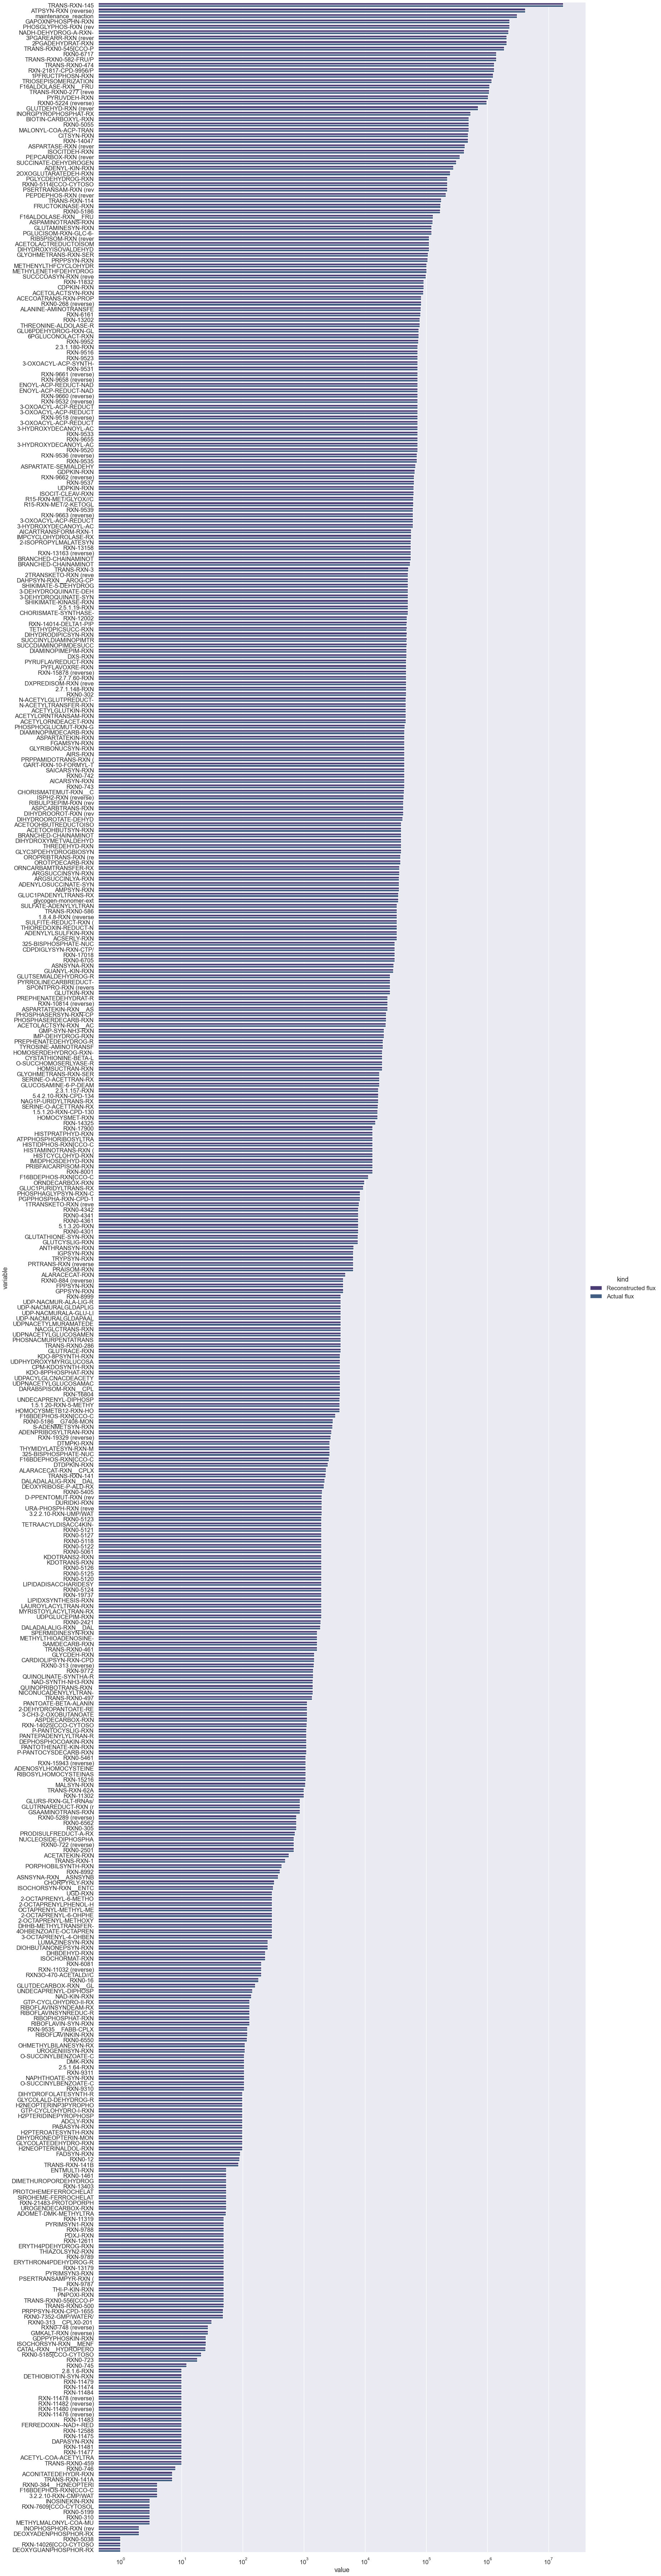

In [35]:
# sort df_reconstr_comp by value
df_reconstr_comp = df_reconstr_comp.sort_values(by="value", ascending=False).reset_index(drop=True)

sns.catplot(y="variable", x="value", hue="kind", data=df_reconstr_comp, kind="bar", height=100, aspect=0.2)

# change x axis to log scale
plt.xscale('log')

# limit length of y axis labels to 20 characters
plt.gca().set_yticklabels([t.get_text()[:20] for t in plt.gca().get_yticklabels()])

# Use the class based method to solve the problem

In [36]:
%load_ext autoreload
%autoreload 2

In [22]:
from convex_kinetics_new import ConvexKineticsNew

In [23]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE)

Number of metabolites: 491, number of reactions: 472, number of flux sets: 1
Number of Km_s: 1001, number of Km_p: 1118, number of Km_i: None, number of Km_a: None
Number of concentrations: (491, 1), number of y_f: (1, 1001), number of y_r: (1, 1118)


In [24]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (1842, 1001), shape of C_beta: (2480, 1118)
Shape of d_alpha: (1842,), shape of d_beta: (2480,)


In [25]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S, y_f, y_r, y_s, y_p, cfwd, crev)

In [26]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, LSE_expr, denom_expr)

In [27]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, lower_bound=-12, upper_bound=18)

In [28]:
problem = E.set_up_problem(loss, constr)


/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [29]:
solution = E.solve(problem)


/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [30]:
solution.value

76.7999127414548